In [3]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    if len(images.shape) == 1:
        images = np.expand_dims(images, axis = 0)
        print(images.shape)
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

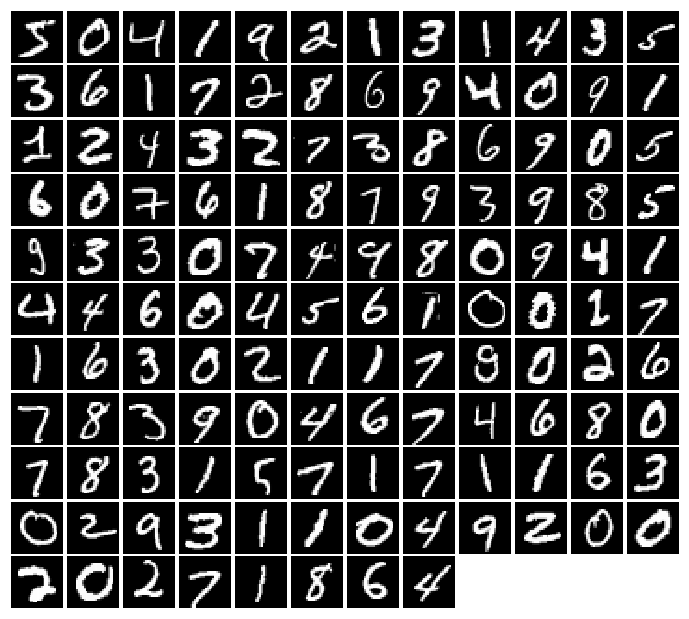

In [5]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000

latent_size = 20
batch_size = 128

mnist_train = dset.MNIST('./datasets/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = dset.MNIST('./datasets/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

In [38]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=1, H=28, W=28):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)
    
def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)

In [62]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.flatten = Flatten()
        self.unflatten = Unflatten()
        self.fc1 = nn.Linear(784, 256)
        self.fc21 = nn.Linear(256, latent_size)
        self.fc22 = nn.Linear(256, latent_size)
        self.fc3 = nn.Linear(latent_size, 256)
        self.fc4 = nn.Linear(256, 784)
        
    def encode(self, x):
        h0 = self.flatten(x)
        h1 = F.relu(self.fc1(h0))
        return self.fc21(h1), self.fc22(h1)
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps, requires_grad = False)
        return eps.mul(std).add_(mu)
    
    def decoder(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.sigmoid(self.fc4(h3))
        return self.unflatten(h4)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar
    

VAE_model = VAE()
if torch.cuda.is_available():
    VAE_model.cuda()    

In [63]:
reconstruction_function_loss = nn.MSELoss(size_average=False)

In [64]:
def loss_function(recon_x, x, mu, logvar):
    MSE_loss = reconstruction_function_loss(recon_x, x)    
    KLD_loss  = torch.sum(mu ** 2 + logvar.exp()) - torch.sum(logvar) - latent_size * batch_size
    return MSE_loss + KLD_loss

In [65]:
optimizer = optim.Adam(VAE_model.parameters(), lr=1e-3)

In [70]:
def run_a_vae(optimizer, model, show_every=250, 
              batch_size=batch_size, num_epochs=10):
    """
    Train a VAE!
    
    Inputs:
    - E_mean, E_var, D: PyTorch models for the discriminator and generator
    - E_solver, D_solver: torch.optim Optimizers to use for training the
      encoder and decoder.
    - KL_divergence_loss, Resconstruct_loss: Functions to use for computing the encoder and
      decoder loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training, in VAE, default value is 1.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """

    model.train()
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in loader_train:
            if len(x) != batch_size:
                continue
                
            optimizer.zero_grad()  
            real_data = Variable(x, requires_grad = False)
            if torch.cuda.is_available():
                real_data = real_data.cuda()
            recon_batch, mu, logvar = model(real_data)
            loss = loss_function(recon_batch, real_data, mu, logvar)
            loss.backward()
            optimizer.step()
            
            if (iter_count % show_every == 0):
                print('Iter: {}, Total loss: {:.4}'.format(iter_count,loss.data[0]))
                imgs_numpy = recon_batch.data.cpu().numpy()
                show_images(imgs_numpy[0:36])
                plt.show()
                print()
            
            iter_count += 1

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iter: 0, Total loss: 4.761e+03


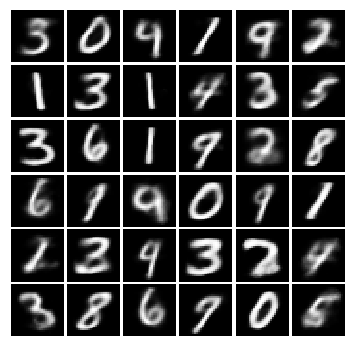


Iter: 250, Total loss: 4.91e+03


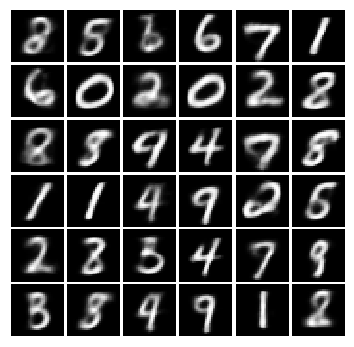


Iter: 500, Total loss: 5.177e+03


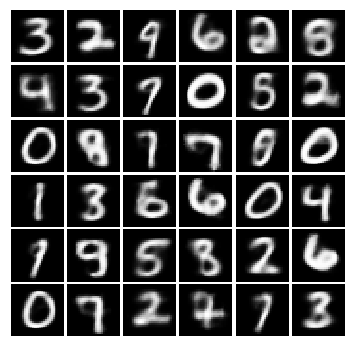


Iter: 750, Total loss: 4.716e+03


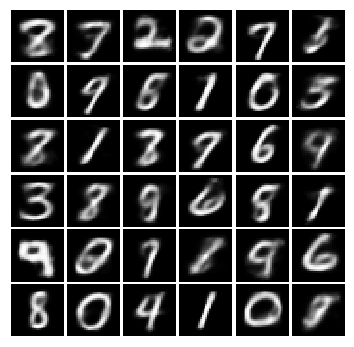


Iter: 1000, Total loss: 5.084e+03


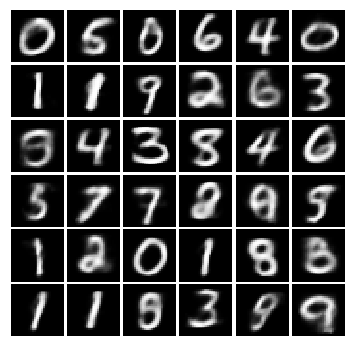


Iter: 1250, Total loss: 5.121e+03


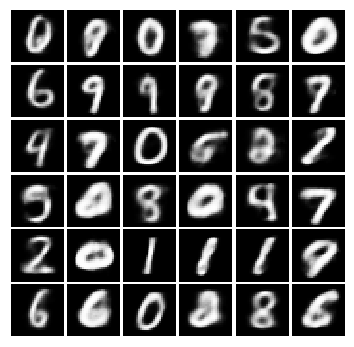


Iter: 1500, Total loss: 5.049e+03


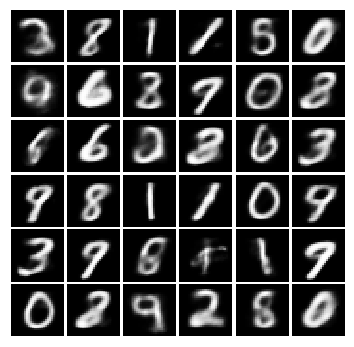


Iter: 1750, Total loss: 4.669e+03


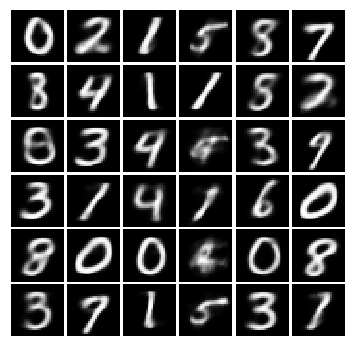


Iter: 2000, Total loss: 4.921e+03


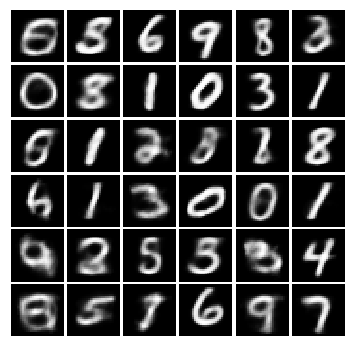


Iter: 2250, Total loss: 4.625e+03


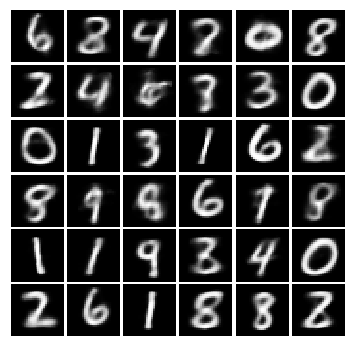


Iter: 2500, Total loss: 4.835e+03


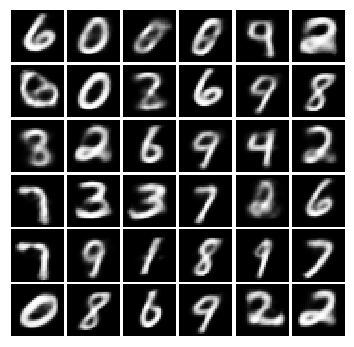


Iter: 2750, Total loss: 4.855e+03


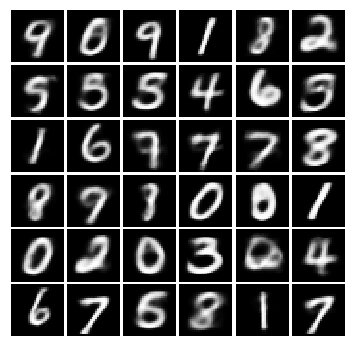


Iter: 3000, Total loss: 4.896e+03


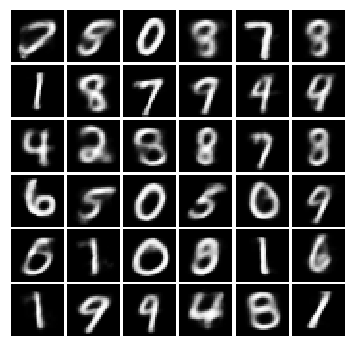


Iter: 3250, Total loss: 4.81e+03


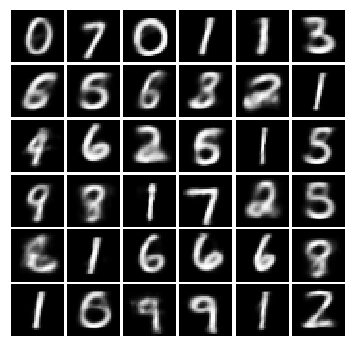


Iter: 3500, Total loss: 5.066e+03


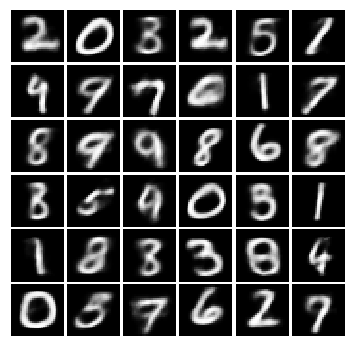


Iter: 3750, Total loss: 4.827e+03


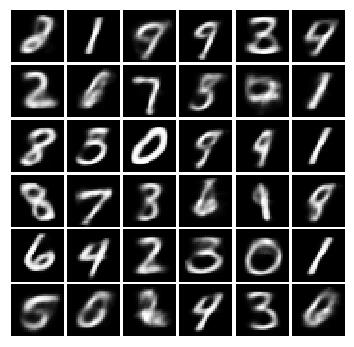


Iter: 4000, Total loss: 4.833e+03


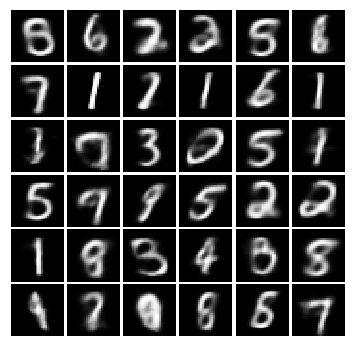


Iter: 4250, Total loss: 4.921e+03


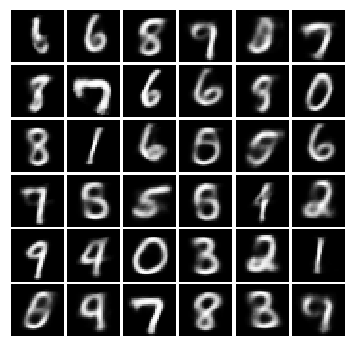


Iter: 4500, Total loss: 4.695e+03


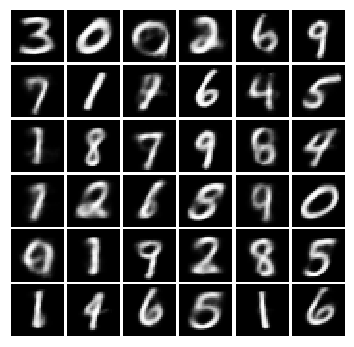


Iter: 4750, Total loss: 4.569e+03


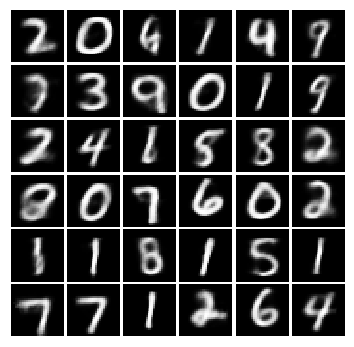


Iter: 5000, Total loss: 4.831e+03


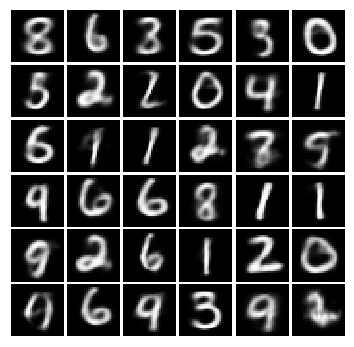


Iter: 5250, Total loss: 5.127e+03


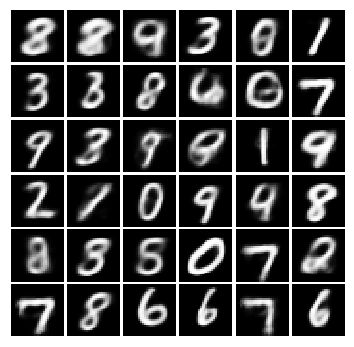


Iter: 5500, Total loss: 4.742e+03


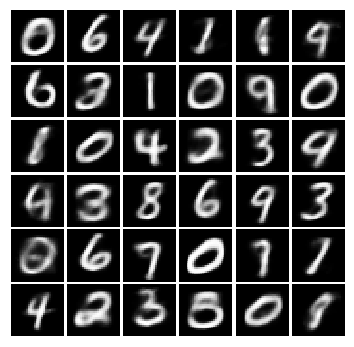


Iter: 5750, Total loss: 4.752e+03


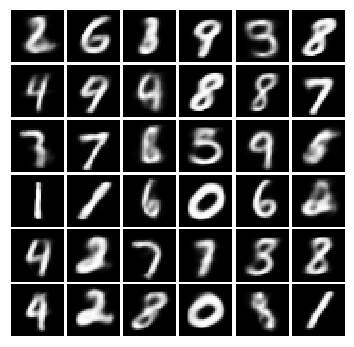


Iter: 6000, Total loss: 4.967e+03


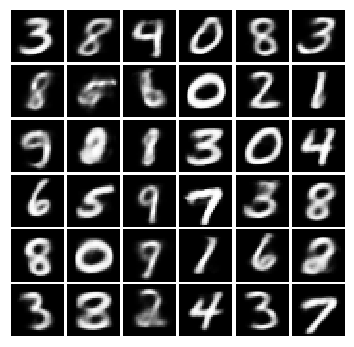


Iter: 6250, Total loss: 5e+03


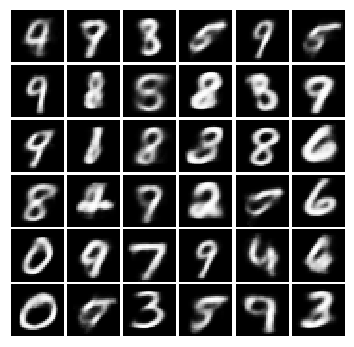


Iter: 6500, Total loss: 4.803e+03


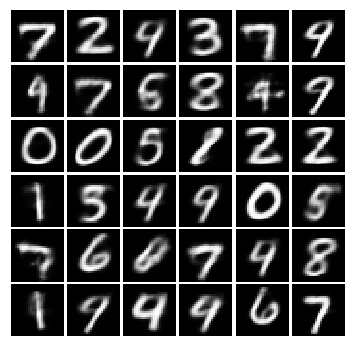


Iter: 6750, Total loss: 4.795e+03


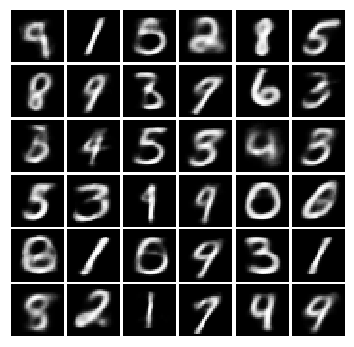


Iter: 7000, Total loss: 5.016e+03


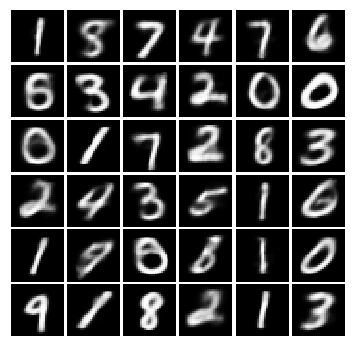


Iter: 7250, Total loss: 4.713e+03


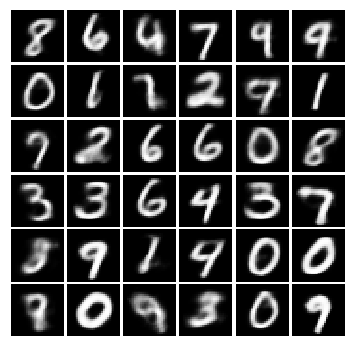


Iter: 7500, Total loss: 4.792e+03


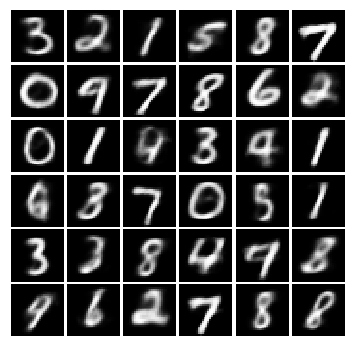


Iter: 7750, Total loss: 4.87e+03


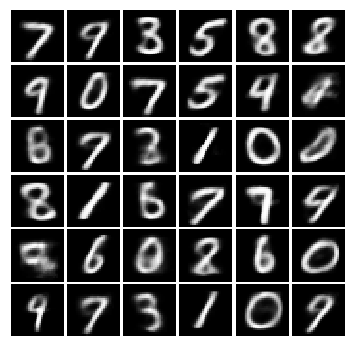


Iter: 8000, Total loss: 4.865e+03


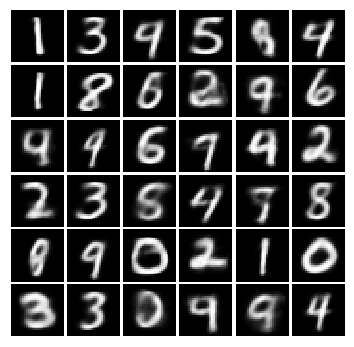


Iter: 8250, Total loss: 4.873e+03


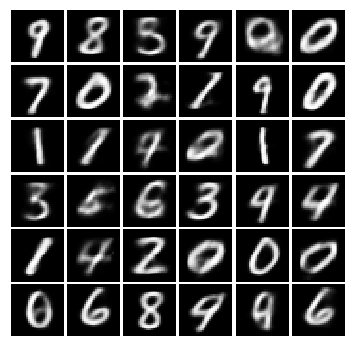


Iter: 8500, Total loss: 4.923e+03


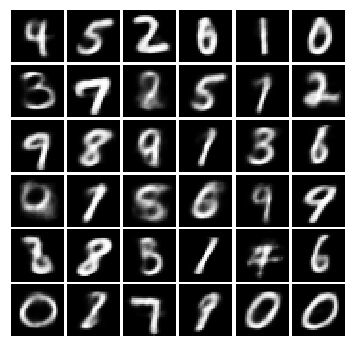


Iter: 8750, Total loss: 4.949e+03


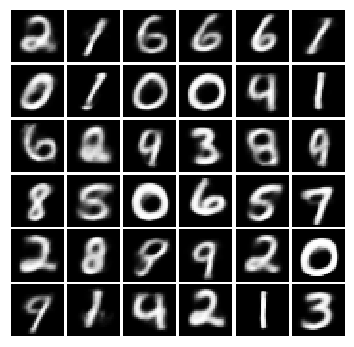


Iter: 9000, Total loss: 4.675e+03


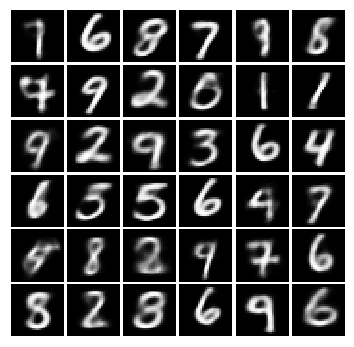


Iter: 9250, Total loss: 4.932e+03


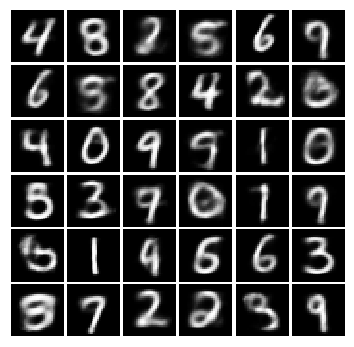


Iter: 9500, Total loss: 4.75e+03


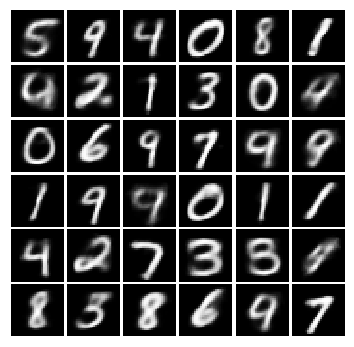


Iter: 9750, Total loss: 4.545e+03


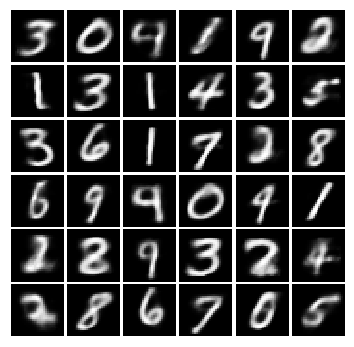


Iter: 10000, Total loss: 4.964e+03


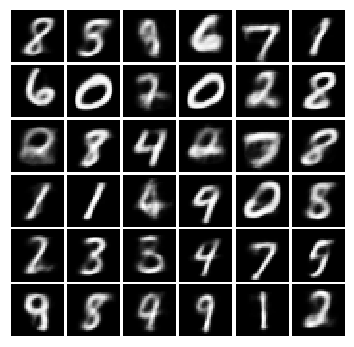


Iter: 10250, Total loss: 5.22e+03


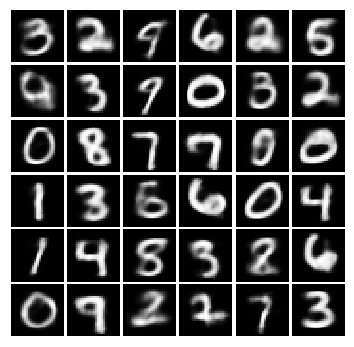


Iter: 10500, Total loss: 4.755e+03


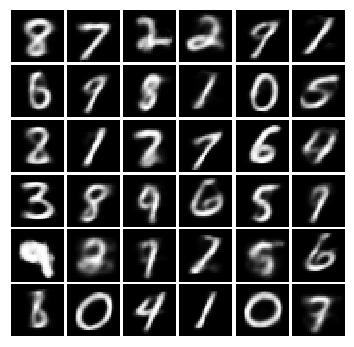


Iter: 10750, Total loss: 4.993e+03


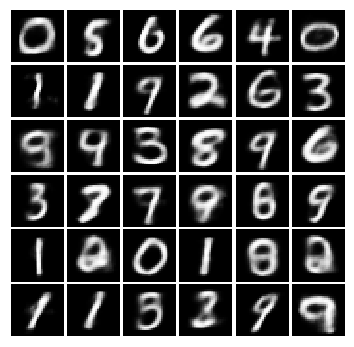


Iter: 11000, Total loss: 5.033e+03


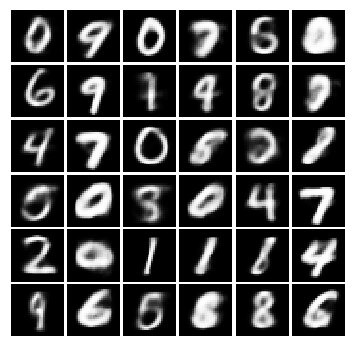


Iter: 11250, Total loss: 4.98e+03


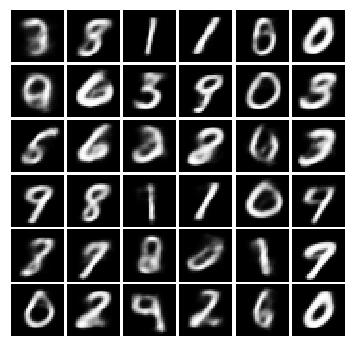


Iter: 11500, Total loss: 4.63e+03


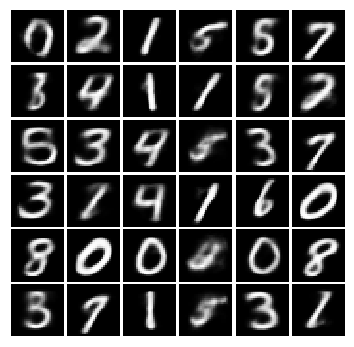


Iter: 11750, Total loss: 4.796e+03


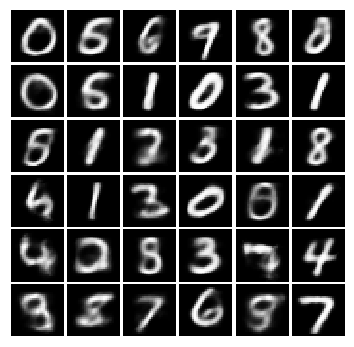


Iter: 12000, Total loss: 4.54e+03


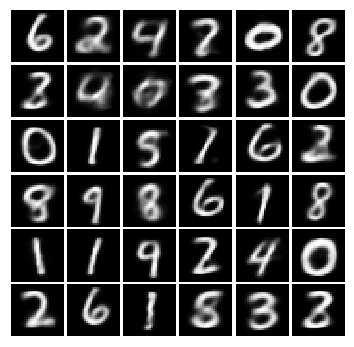


Iter: 12250, Total loss: 4.746e+03


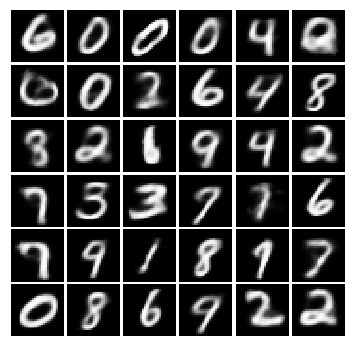


Iter: 12500, Total loss: 4.721e+03


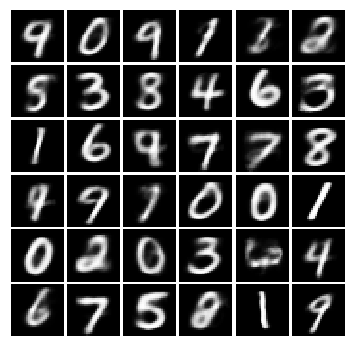


Iter: 12750, Total loss: 4.797e+03


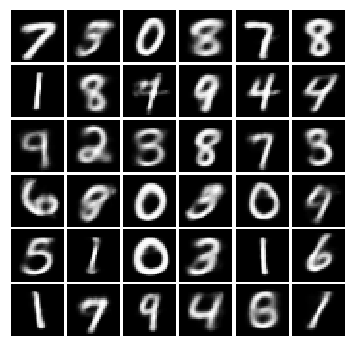


Iter: 13000, Total loss: 4.758e+03


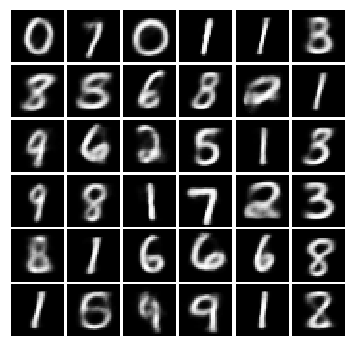


Iter: 13250, Total loss: 5.117e+03


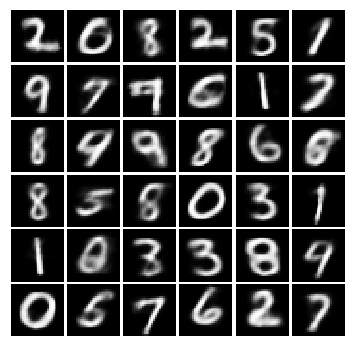


Iter: 13500, Total loss: 4.794e+03


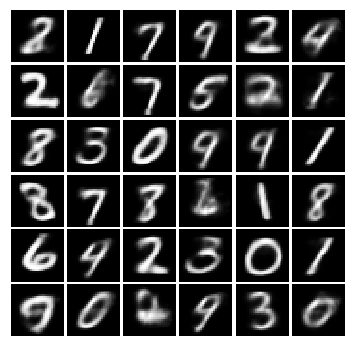


Iter: 13750, Total loss: 4.79e+03


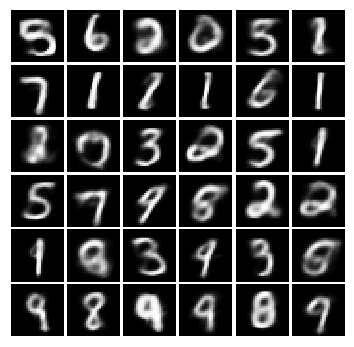


Iter: 14000, Total loss: 4.824e+03


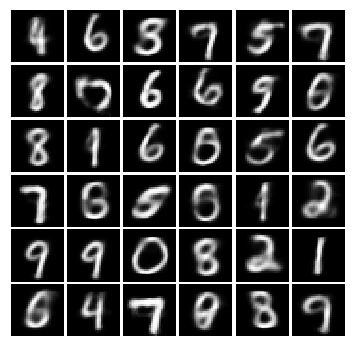


Iter: 14250, Total loss: 4.66e+03


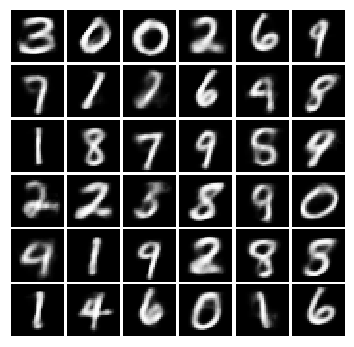


Iter: 14500, Total loss: 4.591e+03


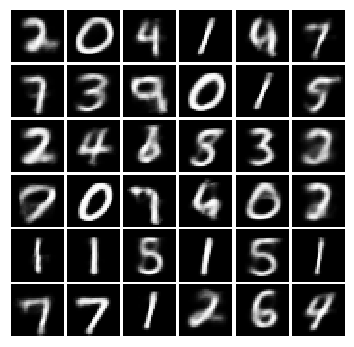


Iter: 14750, Total loss: 4.779e+03


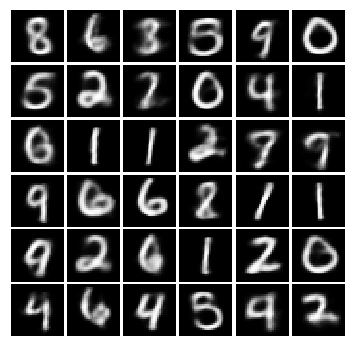


Iter: 15000, Total loss: 5.048e+03


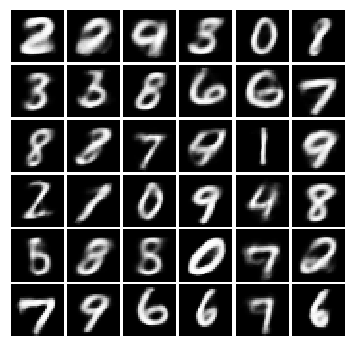


Iter: 15250, Total loss: 4.781e+03


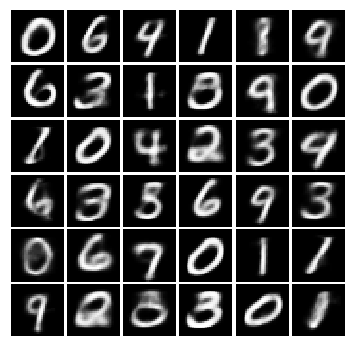


Iter: 15500, Total loss: 4.735e+03


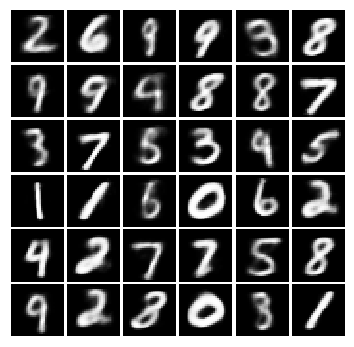


Iter: 15750, Total loss: 4.979e+03


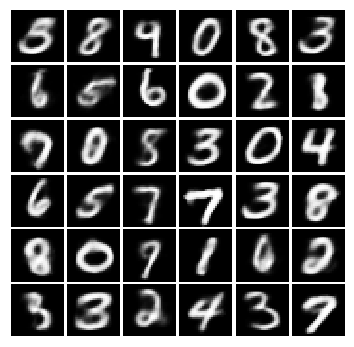


Iter: 16000, Total loss: 4.914e+03


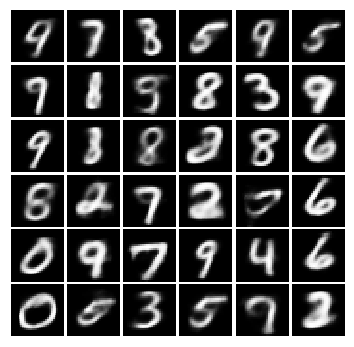


Iter: 16250, Total loss: 4.791e+03


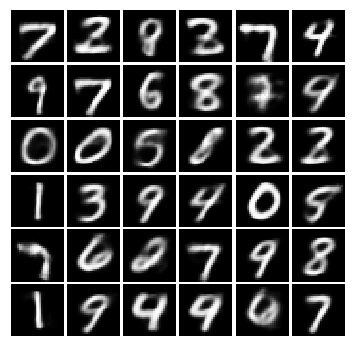


Iter: 16500, Total loss: 4.641e+03


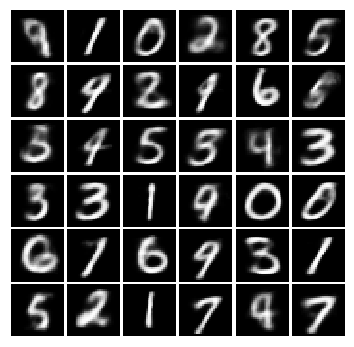

KeyboardInterrupt: 

In [73]:
run_a_vae(optimizer, VAE_model, show_every=250, 
              batch_size=batch_size, num_epochs=50)